In [2]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

from final_dataloader import ImageDataset
import model_from_master as AENet

import argparse
import numpy as np
import sys
import os
import imageio

# adapted from pytorch/examples/vae and ethanluoyc/pytorch-vae
 
# parse arguments

options = argparse.ArgumentParser()

options.add_argument('--save-dir', action="store", dest="save_dir", default="my_save_dir")
options.add_argument('-pt', action="store", dest="pretrained_file", default=None)
options.add_argument('-bs', action="store", dest="batch_size", default = 128, type = int)
options.add_argument('-ds', action="store", dest="datadir", default = "data_folder/my_data//")

options.add_argument('-iter', action="store", dest="max_iter", default = 800, type = int) #800
options.add_argument('-lr', action="store", dest="lr", default=1e-3, type = float)
options.add_argument('-nz', action="store", dest="nz", default=128, type = int)
options.add_argument('-lamb', action="store", dest="lamb", default=0.0000001, type = float)
options.add_argument('-lamb2', action="store", dest="lamb2", default=0.001, type = float)
options.add_argument('--conditional', action="store_true")

args, unknown = options.parse_known_args()
os.makedirs(args.save_dir, exist_ok=True)
with open(os.path.join(args.save_dir, "log.txt"), 'w') as f:
    print(args, file=f)

# retrieve dataloader
trainset = ImageDataset(datadir=args.datadir, mode='train')
testset = ImageDataset(datadir=args.datadir, mode='test')

train_loader = DataLoader(trainset, batch_size=args.batch_size, drop_last=False, shuffle=True)
test_loader = DataLoader(testset, batch_size=args.batch_size, drop_last=False, shuffle=False)

print('Data loaded')
 
model = AENet.VAE(latent_variable_size=args.nz, batchnorm=True)
if args.conditional:
    netCondClf = AENet.Simple_Classifier(nz=args.nz)

if args.pretrained_file is not None:
    model.load_state_dict(torch.load(args.pretrained_file))
    print("Pre-trained model loaded")
    sys.stdout.flush()

CE_weights = torch.FloatTensor([4.5, 0.5])
 
if torch.cuda.is_available():
    print('Using GPU')
    model.cuda()
    CE_weights = CE_weights.cuda()
    if args.conditional:
        netCondClf.cuda()

CE = nn.CrossEntropyLoss(CE_weights)
 
if args.conditional:
    optimizer = optim.Adam(list(model.parameters())+list(netCondClf.parameters()), lr = args.lr)
else:
    optimizer = optim.Adam([{'params': model.parameters()}], lr = args.lr)

def loss_function(recon_x, x, mu, logvar, latents):
    MSE = nn.MSELoss()
    lloss = MSE(recon_x,x)

    if args.lamb>0:
        KL_loss = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        lloss = lloss + args.lamb*KL_loss

    return lloss
 
def train(epoch):
    model.train()
    if args.conditional:
        netCondClf.train()

    train_loss = 0
    total_clf_loss = 0

    for batch_idx, samples in enumerate(train_loader):
        print("hi")
 
        inputs = Variable(samples['image_tensor'])
        if torch.cuda.is_available():
            inputs = inputs.cuda()
 
        optimizer.zero_grad()
        recon_inputs, latents, mu, logvar = model(inputs)
        loss = loss_function(recon_inputs, inputs, mu, logvar, latents)
        train_loss += loss.data.item() * inputs.size(0)
        
        if args.conditional:
            targets = Variable(samples['binary_label'])
            if torch.cuda.is_available():
                targets = targets.cuda()
            clf_outputs = netCondClf(latents)
            class_clf_loss = CE(clf_outputs, targets.view(-1).long())
            loss += args.lamb2 * class_clf_loss
            total_clf_loss += class_clf_loss.data.item() * inputs.size(0)
 
        loss.backward()
        optimizer.step()

    with open(os.path.join(args.save_dir, "log.txt"), 'a') as f:
        print('Epoch: {} Average loss: {:.15f} Clf loss: {:.15f} '.format(epoch, train_loss / len(train_loader.dataset), total_clf_loss / len(train_loader.dataset)), file=f)
 
def test(epoch):
    model.eval()
    if args.conditional:
        netCondClf.eval()

    test_loss = 0
    total_clf_loss = 0

    for i, samples in enumerate(test_loader):
 
        inputs = Variable(samples['image_tensor'])
        if torch.cuda.is_available():
            inputs = inputs.cuda()
 
        recon_inputs, latents, mu, logvar = model(inputs)
        
        loss = loss_function(recon_inputs, inputs, mu, logvar, latents)
        test_loss += loss.data.item() * inputs.size(0)
        
        if args.conditional:
            targets = Variable(samples['binary_label'])
            if torch.cuda.is_available():
                targets = targets.cuda()
            clf_outputs = netCondClf(latents)
            class_clf_loss = CE(clf_outputs, targets.view(-1).long())
            total_clf_loss += class_clf_loss.data.item() * inputs.size(0)

    test_loss /= len(test_loader.dataset)
    total_clf_loss /= len(test_loader.dataset)

    with open(os.path.join(args.save_dir, "log.txt"), 'a') as f:
        print('Test set loss: {:.15f} Test clf loss: {:.15f}'.format(test_loss, total_clf_loss), file=f)
    
    return test_loss
 
 
def save(epoch):
    model_dir = os.path.join(args.save_dir, "models")
    os.makedirs(model_dir, exist_ok=True)
    torch.save(model.cpu().state_dict(), os.path.join(model_dir, str(epoch)+".pth"))
    if torch.cuda.is_available():
        model.cuda()
 
def generate_image(epoch):
    img_dir = os.path.join(args.save_dir, "images")
    os.makedirs(img_dir, exist_ok=True)
    model.eval()

    for i in range(5):
        samples = train_loader.dataset[np.random.randint(30)]
        inputs = samples['image_tensor']
        inputs = Variable(inputs.view(1,1,64,64))
 
        if torch.cuda.is_available():
            inputs = inputs.cuda()
 
        recon_inputs, _, _, _ = model(inputs)
 
        imageio.imwrite(os.path.join(img_dir, "Train_epoch_%s_inputs_%s.jpg" % (epoch, i)), np.uint8(inputs.cpu().data.view(64,64).numpy()*255))
        imageio.imwrite(os.path.join(img_dir, "Train_epoch_%s_recon_%s.jpg" % (epoch, i)), np.uint8(recon_inputs.cpu().data.view(64,64).numpy()*255))
 
        samples = test_loader.dataset[np.random.randint(5)]
        inputs = samples['image_tensor']
        inputs = Variable(inputs.view(1,1,64,64))
 
        if torch.cuda.is_available():
            inputs = inputs.cuda()
 
        recon_inputs, _, _, _ = model(inputs)
 
        imageio.imwrite(os.path.join(img_dir, "Test_epoch_%s_inputs_%s.jpg" % (epoch, i)), np.uint8(inputs.cpu().data.view(64,64).numpy()*255))
        imageio.imwrite(os.path.join(img_dir, "Test_epoch_%s_recon_%s.jpg" % (epoch, i)), np.uint8(recon_inputs.cpu().data.view(64,64).numpy()*255))
 
# main training loop
generate_image(0)
save(0)
 
_ = test(0)

for epoch in range(args.max_iter):
    print(epoch)
    train(epoch)
    _ = test(epoch)
 
    if epoch % 100 == 1:
        generate_image(epoch)
        save(epoch)

Data loaded
Using GPU
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271


In [5]:
# visualise latent space
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as mcolors

def plot_latent_space_with_labels(data_loader, model):
    model = model.cuda()
    for i, dict in enumerate(data_loader):
        print("hello")
        labels = dict["label"]
    
    d = {i:[] for i in labels}

    with torch.no_grad():
        for i, dict in enumerate(data_loader):
            
            images = dict["image_tensor"]
            labels = dict["label"]
            
            embedding = model.get_latent_var(images.cuda())

            for i, name in zip(range(len(labels)), labels):
                
                d[name].append(embedding[i].to("cpu").numpy())
    
    
    colors = list(mcolors.CSS4_COLORS.items())*10
    for i,j in zip(labels, range(len(labels))):
        d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][0], d[i][1],
            color=colors[j][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()

hello


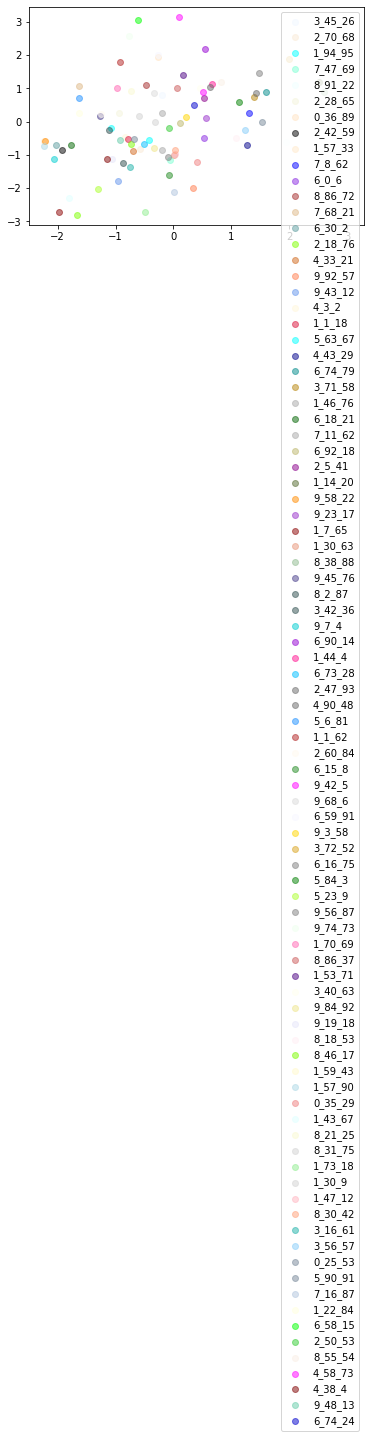

In [6]:
# I'm currently plotting the first and second latent variable
plot_latent_space_with_labels(
    data_loader=train_loader,
    model=model.cuda())

plt.legend()
plt.show()